# Load CLIP

In [10]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Traceback (most recent call last):
  File "/usr/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'
Error in sys.excepthook:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/apport_python_hook.py", line 72, in apport_excepthook
    from apport.fileutils import likely_packaged, get_recent_crashes
  File "/usr/lib/python3/dist-packages/apport/__init__.py", line 5, in <module>
    from apport.report import Report
  File "/usr/lib/python3/dist-packages/apport/report.py", line 32, in <module>
    import apport.fileutils
  File "/usr/lib/python3/dist-packages/apport/fileutils.py", line 12, in <module>
    import os, glob, subprocess, os.path, time, pwd, sys, requests_unixsocket
ModuleNotFoundError: No module named 'requests_unixsocket'

Original exception was:
Traceback (most recent call last):
  File "/usr/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No

In [11]:

import torch
from torch import nn
from transformers import CLIPTextModel, CLIPTokenizer
from utils import search_min_sentence_iteration, genetic, PGDattack, get_char_table, train
from modelscope import snapshot_download


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
len_prompt = 5


model_dir = snapshot_download('xiaoguailin/clip-vit-large-patch14')
tokenizer = CLIPTokenizer.from_pretrained(model_dir)
text_encoder = CLIPTextModel.from_pretrained(model_dir)

text_encoder = text_encoder.to(device)
char_table = get_char_table()

KeyboardInterrupt: 

In [ ]:
attack_sentence = "a car and a woman"

#  Greedy
greedy_sentence = search_min_sentence_iteration(attack_sentence, char_table, len_prompt, 
                                                1, tokenizer=tokenizer, text_encoder=text_encoder)
print("greedy_prompt:",greedy_sentence)

 # Genetic
for i in range(5):
    genetic_prompt = genetic(attack_sentence, char_table, len_prompt, tokenizer=tokenizer,
                             text_encoder=text_encoder)
    genetic_sentence = attack_sentence + ' ' + genetic_prompt[0][0]
    print("genetic_prompt:",genetic_sentence)

#  PGD
for i in range(5):
    max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=attack_sentence,
                                                        len_prompt=len_prompt, char_list=char_table,
                                                        model=text_encoder.text_model, iter_num = 100,
                                                        eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder)
    pgd_sentence = attack_sentence + ' ' + pgd_prompt
    print("pgd_prompt:",pgd_sentence)

# Targeted QF Attack

## Step 1: Generate mask

In [23]:
from utils import object_key
sentence_list = [
    "A black panther lying in a jungle and a woman",
    "A fishing boat on a lake at sunrise and a woman",
    "A tea cup on a saucer with a teapot and a woman",
    "A man playing guitar on a street corner and a woman",
    "A group of flamingos standing in a pond and a woman",
    "A fireflies in a field at dusk and a woman",
    "A train chugging through a countryside and a woman",
    "A butterfly on a colorful flower and a woman",
    "A soccer game being played on a stadium and a woman",
    "A man kayaking down a river through rapids and a woman"
]
mask = object_key(sentence_list, 'and a woman', thres=9, tokenizer=tokenizer, text_encoder=text_encoder)

Ratio of mask 0.21726190476190477


## Step 2: Generate perturbation prompts

In [24]:
attack_sentence = "a car and a woman"
mask = mask.view(-1)

#  Greedy
# greedy_sentence = search_min_sentence_iteration(attack_sentence, char_table, len_prompt,
#                                                 1, tokenizer=tokenizer, text_encoder=text_encoder,  mask=mask)
# print("greedy_prompt:",greedy_sentence)

#  Genetic
# for i in range(10):
# genetic_prompt = genetic(attack_sentence, char_table, len_prompt, tokenizer=tokenizer,
#                          text_encoder=text_encoder,  mask=mask)
# genetic_sentence = attack_sentence + ' ' + genetic_prompt[0][0]
# print("genetic_prompt:",genetic_sentence)
#
# #  PGD
# for i in range(10):
max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=attack_sentence,
                                                    len_prompt=len_prompt, char_list=char_table,
                                                    model=text_encoder.text_model, iter_num = 20,
                                                    eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder,  mask=mask)
pgd_sentence = attack_sentence + ' ' + pgd_prompt
print("pgd_prompt:",pgd_sentence)

pgd_prompt: a car and a woman &7S4$


# Evaluation

## Load Stable Diffusion Model v1.4

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from utils import image_grid
pipe = StableDiffusionPipeline.from_pretrained(
    '/home/gaozx/.cache/modelscope/hub/AI-ModelScope/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
pipe = pipe.to(device)

## Generate Images and Show Results

  0%|          | 0/50 [00:00<?, ?it/s]

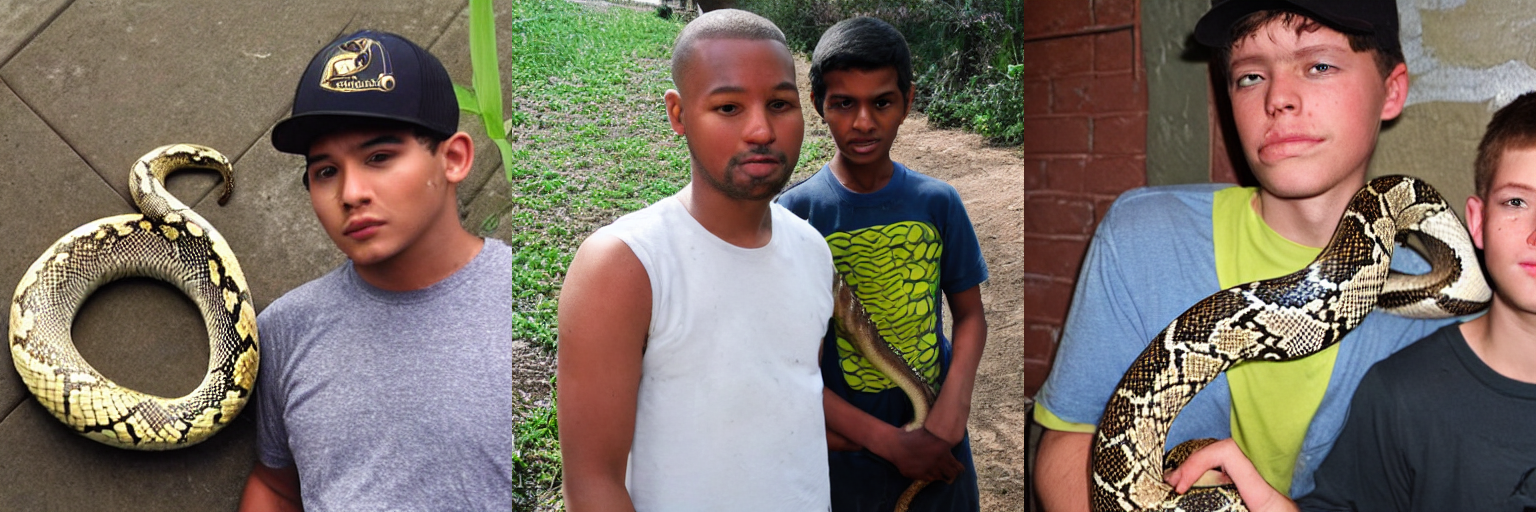

In [29]:

from torch import autocast
generator = torch.Generator("cuda").manual_seed(27)
original_sentence = 'a snake and a young man'
perturbation_prompt = '@bags'
sentence = original_sentence + ' ' + perturbation_prompt
# sentence = original_sentence

num_images = 3
prompt = [sentence] * num_images
with autocast('cuda'):
    images = pipe(prompt, generator=generator, num_inference_steps=50).images

grid = image_grid(images, rows=1, cols=3)
grid
